# Spheres from weights

[NiftiSpheresMasker documentation](https://nilearn.github.io/stable/modules/generated/nilearn.maskers.NiftiSpheresMasker.html)

In [7]:
import os
import pandas as pd
import numpy as np
from nilearn.maskers import NiftiSpheresMasker
from nilearn.image import math_img
from nilearn.glm import threshold_stats_img

In [8]:
# Settings
data_dir = "/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2/"
glm_dir = os.path.join(data_dir, "derivatives", "nilearn_glm")
# out_dir_group = os.path.join(data_root, "derivatives", "nilearn_glm", "group")
stab_mask_dir = os.path.join(data_dir, "derivatives", "mvpa_08_stability_bold", "stab_full_masks")  # for stability masks

# Threshold values
hc = "fpr"  # None, 'bonferroni', 'fdr'
ct = 20  # cluster threshold
alpha = 0.001  # p-value threshold

emotion_names = [
    "JoyfulActivation",
    "Nostalgia",
    "Peacefulness",
    "Power",
    "Sadness",
    "Tenderness",
    "Tension",
    "Transcendence",
    "Wonder",
]

factors_names = [
    "Sublimity",
    "Vitality",
    "Unease",
]

subject_list = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20"]

In [9]:
# Clusters
cluster_file_path = "out_atlasreader/atlas_ALL_peaks.csv"

df = pd.read_csv(cluster_file_path)

# Extract the coordinates
coords = df[["peak_x", "peak_y", "peak_z"]].values
coords

array([[-56.5, -16.5,   3.5],
       [ 57.5, -10.5,   3.5],
       [-10.5,  -6.5,  65.5],
       [ 55.5,  -4.5,  43.5],
       [-18.5, -66.5,  47.5],
       [ 39.5,  59.5,  -8.5],
       [ 33.5, -66.5,  47.5],
       [-48.5,  13.5,  27.5],
       [-18.5,  63.5,  17.5],
       [-64.5, -56.5,  -6.5],
       [-50.5,  27.5,  -8.5],
       [ 37.5,  45.5,  33.5],
       [ 11.5, -64.5,  33.5],
       [ 57.5, -60.5,  -4.5],
       [ 55.5,  33.5,   3.5],
       [ 65.5, -52.5,   9.5],
       [ 59.5, -42.5,  45.5],
       [-24.5,  -4.5, -18.5],
       [ 63.5, -28.5, -18.5],
       [  3.5, -36.5,  45.5],
       [ 43.5, -64.5, -32.5],
       [  5.5, -22.5,  43.5],
       [-56.5,  19.5,  13.5],
       [  7.5, -76.5,  55.5],
       [ -8.5,  49.5,  -6.5],
       [-40.5,  55.5, -12.5],
       [ 25.5,  61.5,  17.5]])

In [10]:
# import nibabel as nib
# from nilearn.image import resample_img
# import templateflow.api as tflow

# t1w_gm_img = tflow.get("MNI152NLin2009cAsym", label="GM", suffix="probseg", resolution=2, extension="nii.gz")

# # load, threshold, and resample the GM mask
# gm_prob_mask = nib.load(t1w_gm_img)
# gm_mask = math_img("img > 0.15", img=gm_prob_mask)

# mask_img_example = nib.load(os.path.join(stab_mask_dir, "sub-01_STAB_mask.nii.gz"))
# gm_mask_resampled = resample_img(gm_mask, target_affine=mask_img_example.affine, target_shape=mask_img_example.shape[0:3], interpolation="nearest")


In [12]:
# Initalize array to store the z-scores (size = subjects x number of emotions x number of clusters)
z_scores = np.zeros((len(subject_list), len(emotion_names), len(coords)))


for i, sub in enumerate(subject_list):
    print(f"Processing subject {sub}...")

    # Iterate over the emotions
    for j, emotion in enumerate(emotion_names):
        # Load the z-score map
        z_map_path = os.path.join(glm_dir, f"sub-{sub}_task-02a_stat-z_con-{emotion}.nii.gz")  # sub-01_task-02a_stat-z_con-Peacefulness.nii.gz

        z_map_thres, _ = threshold_stats_img(z_map_path, alpha=alpha, height_control=hc, cluster_threshold=ct)

        # binary mask based on z_map_thres
        z_map_mask = math_img("img > 0", img=z_map_thres)
        # z_map_pos = math_img("np.maximum(img, 0)", img=z_map_path)

        # Define Masker
        masker = NiftiSpheresMasker(
            mask_img=z_map_mask,
            seeds=coords,
            radius=4,
            detrend=False,
            standardize=False,
        )

        z_scores[i, j, :] = masker.fit_transform(z_map_thres)

Processing subject 01...


ValueError: These spheres are empty: [ 2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]

In [5]:
# find all values that are exactly zero and replace with NaNs
print(f"There are {np.sum(z_scores == 0)} zeros in the z-scores.")
z_scores_clean = z_scores.copy()
z_scores_clean[z_scores_clean == 0] = np.nan

There are 36 zeros in the z-scores.


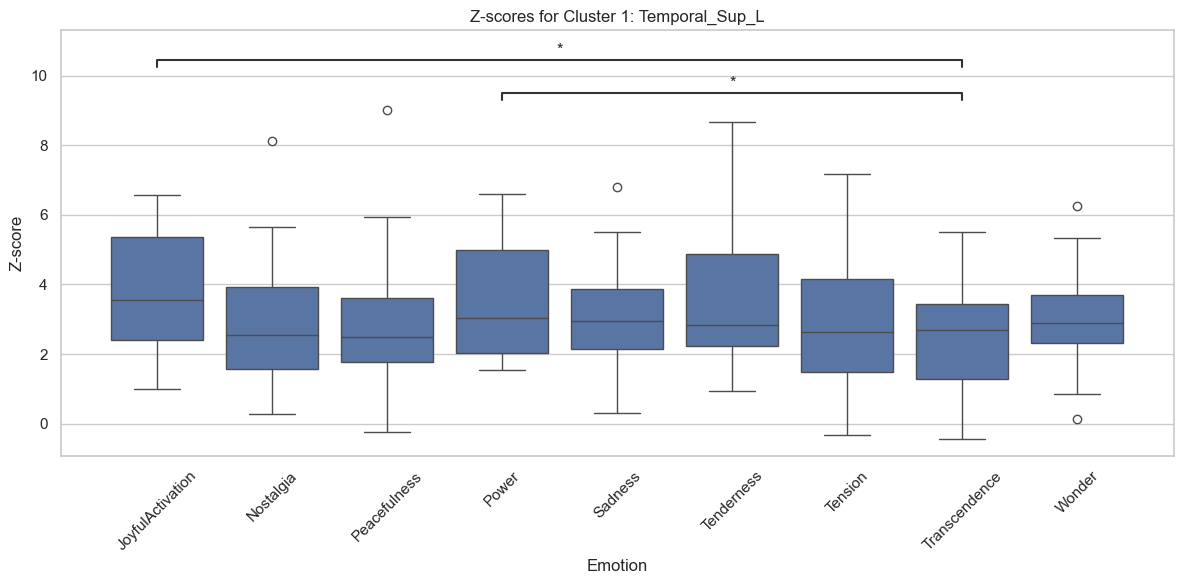

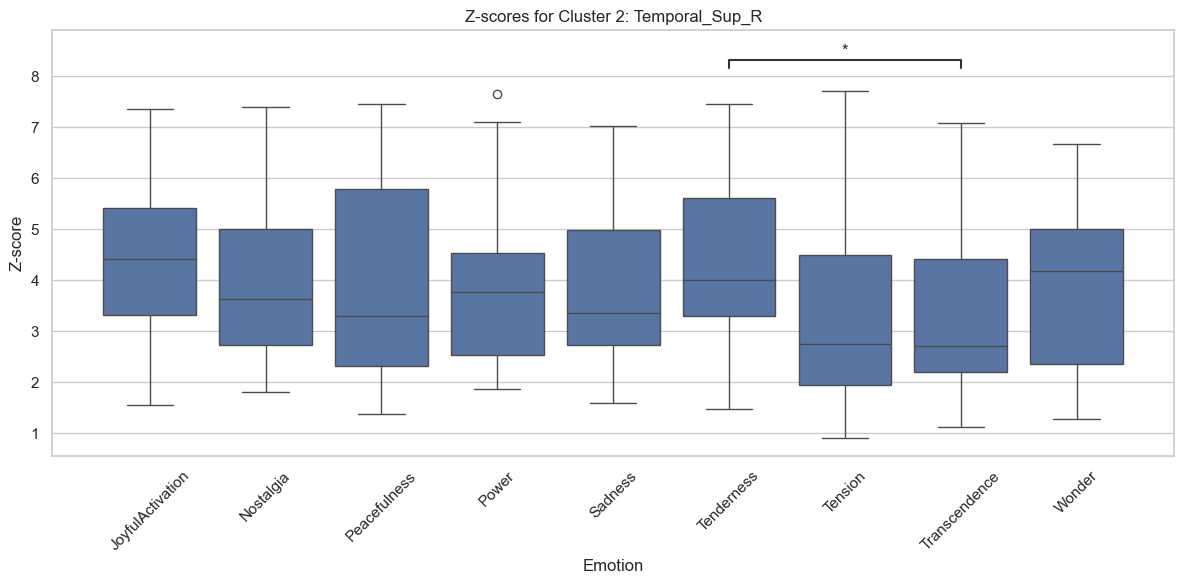

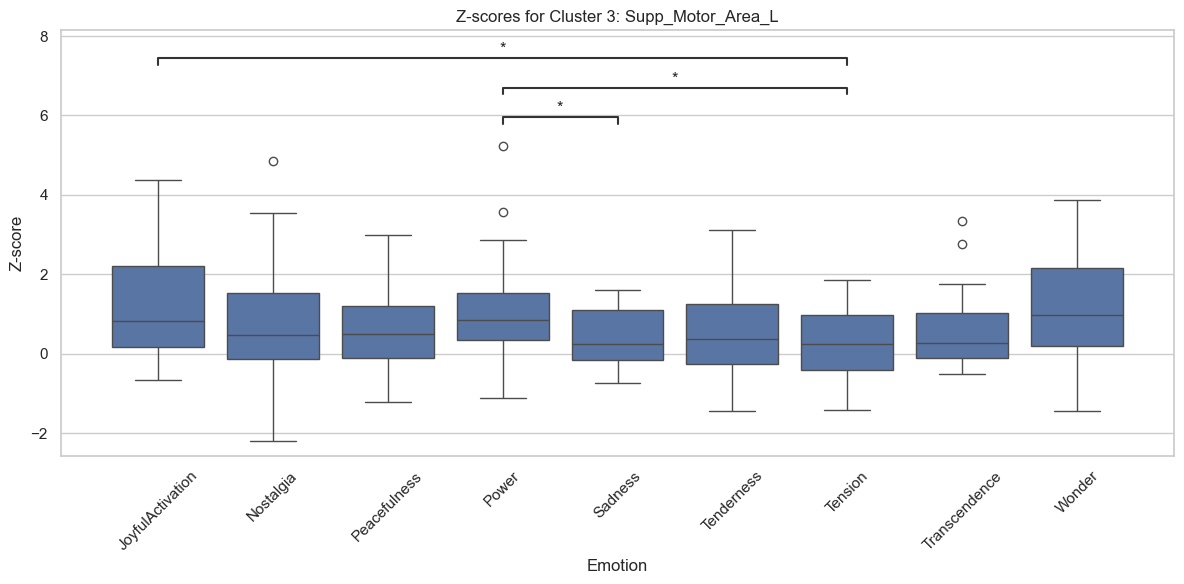

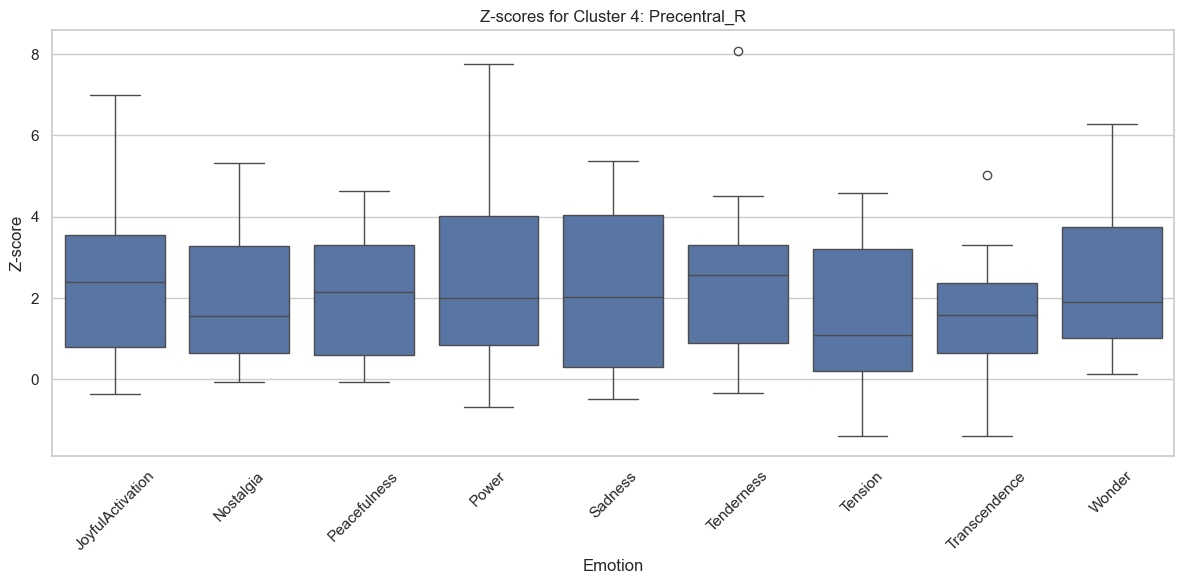

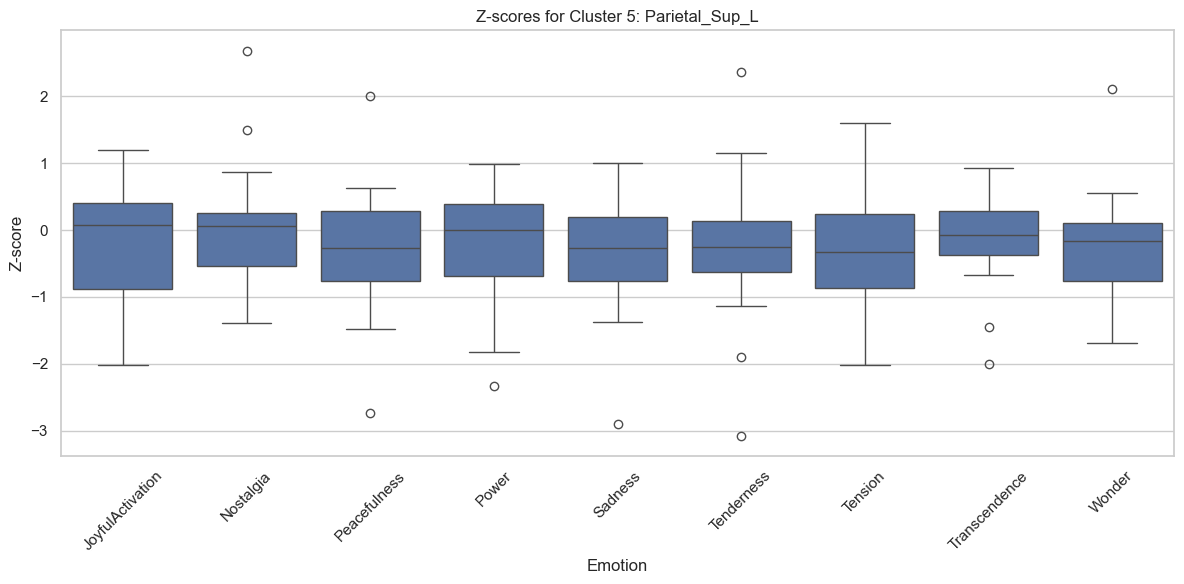

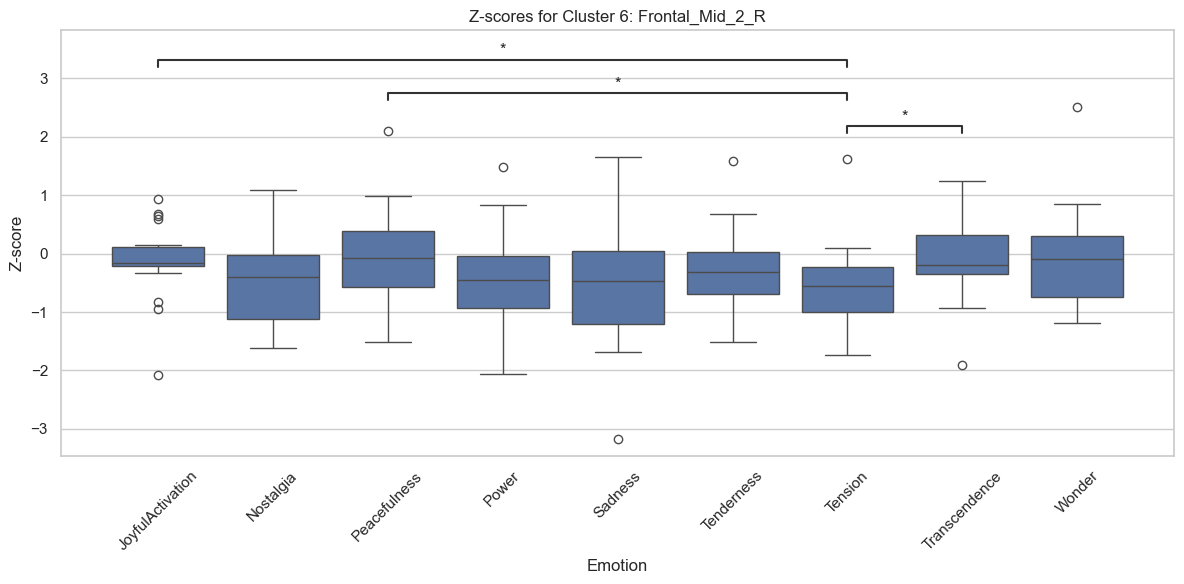

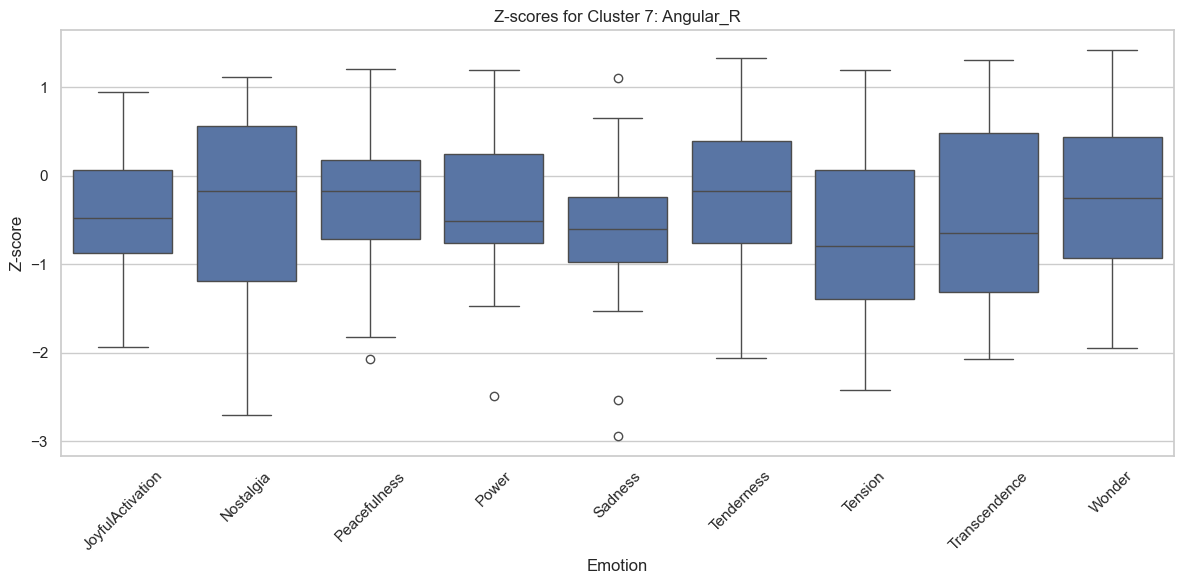

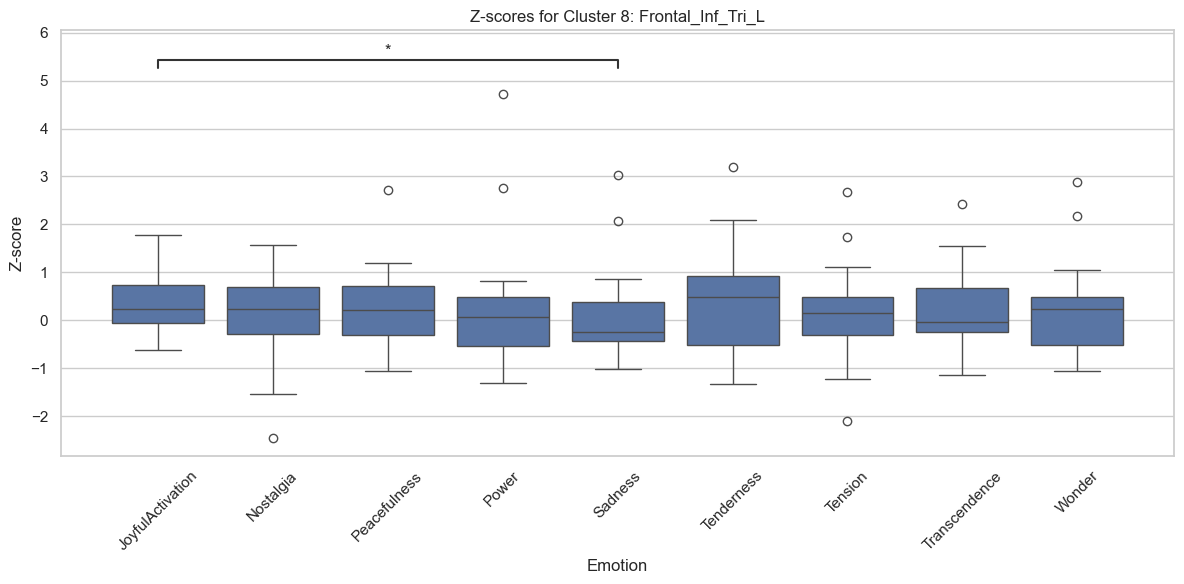

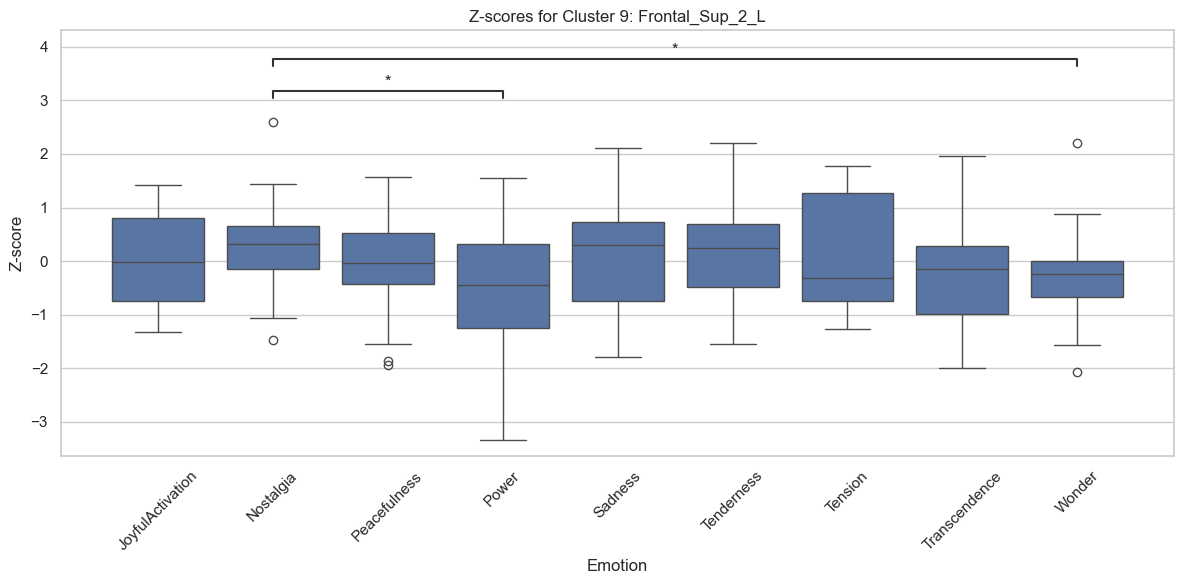

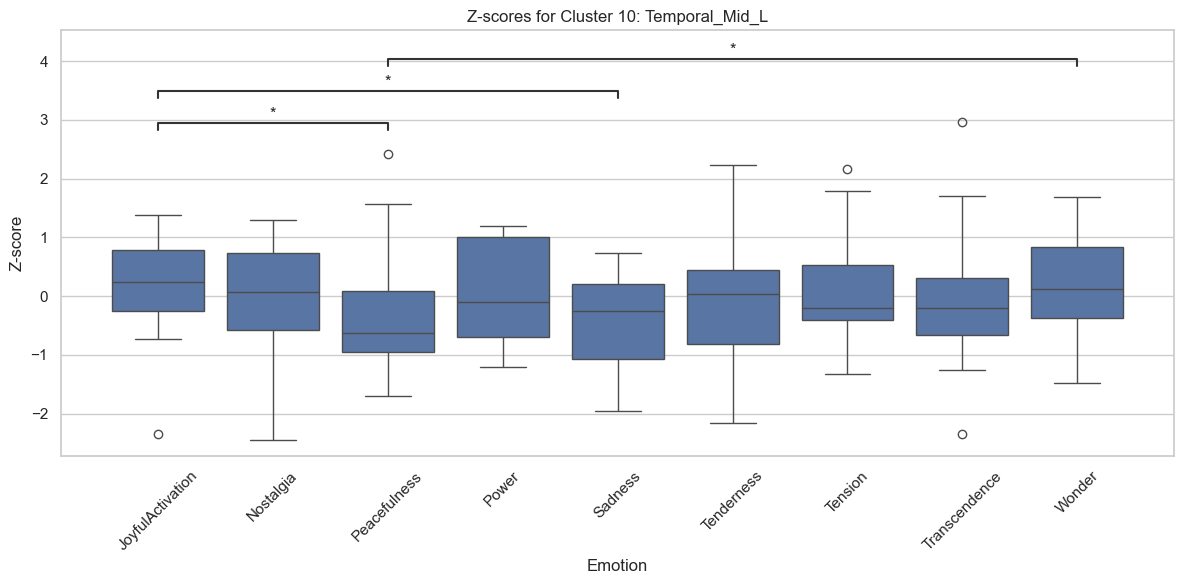

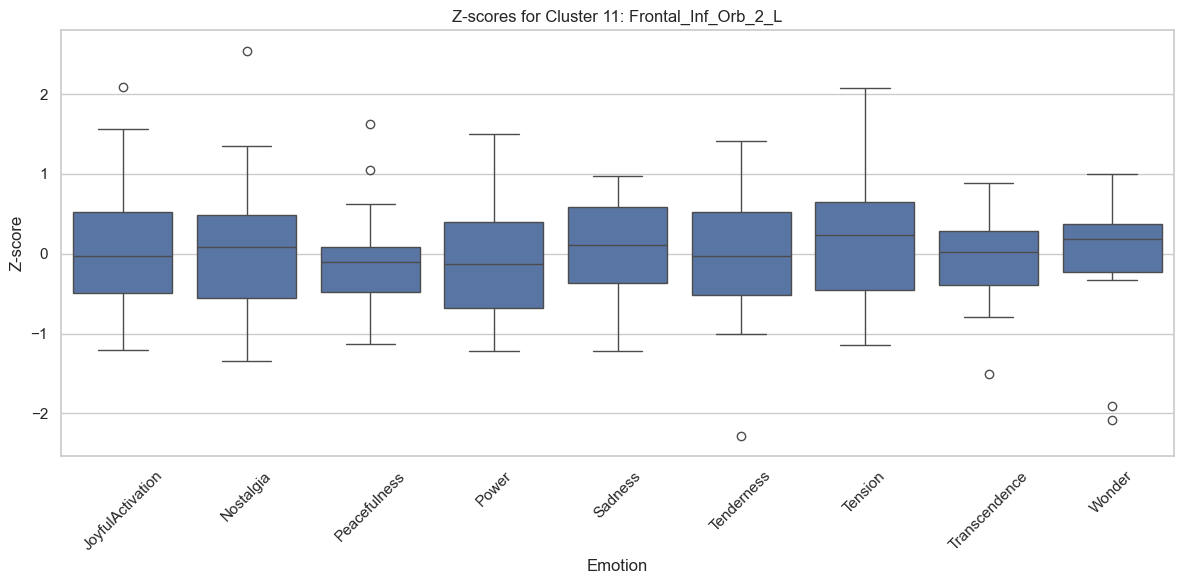

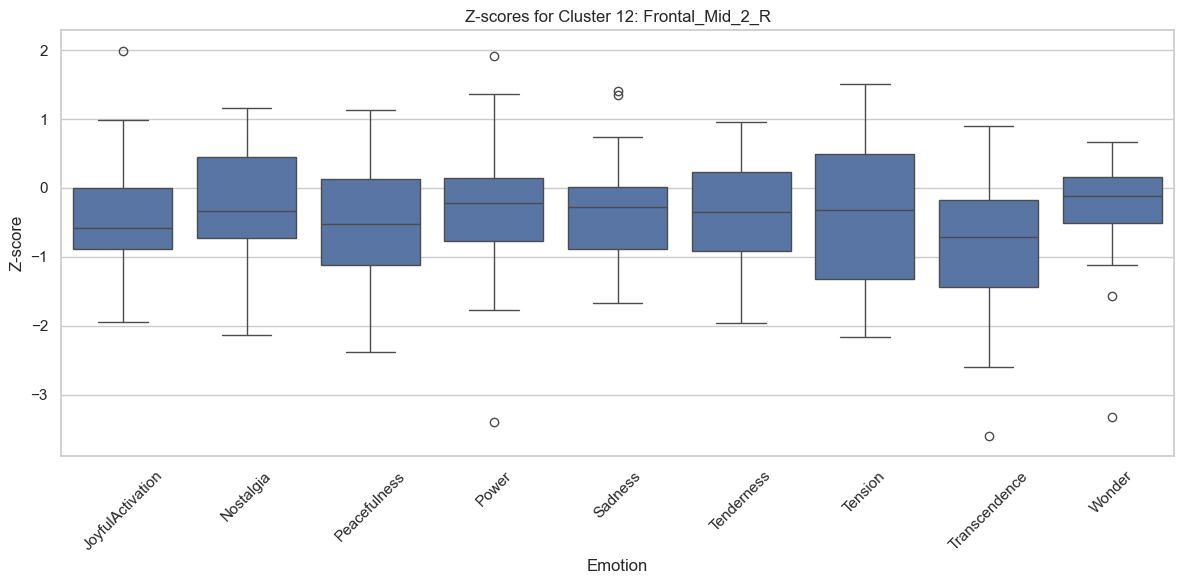

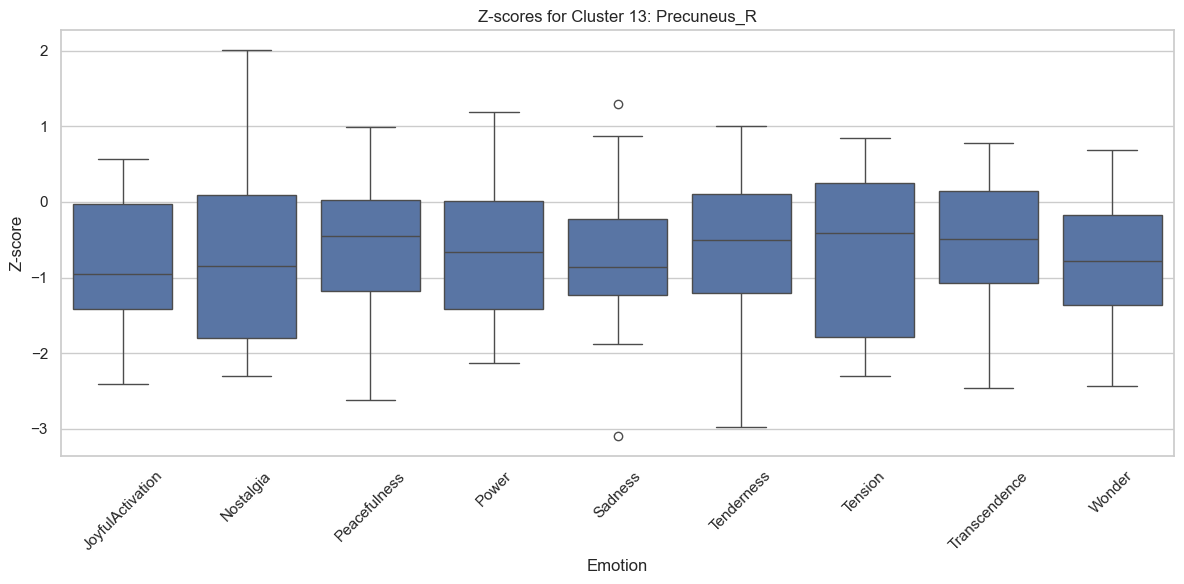

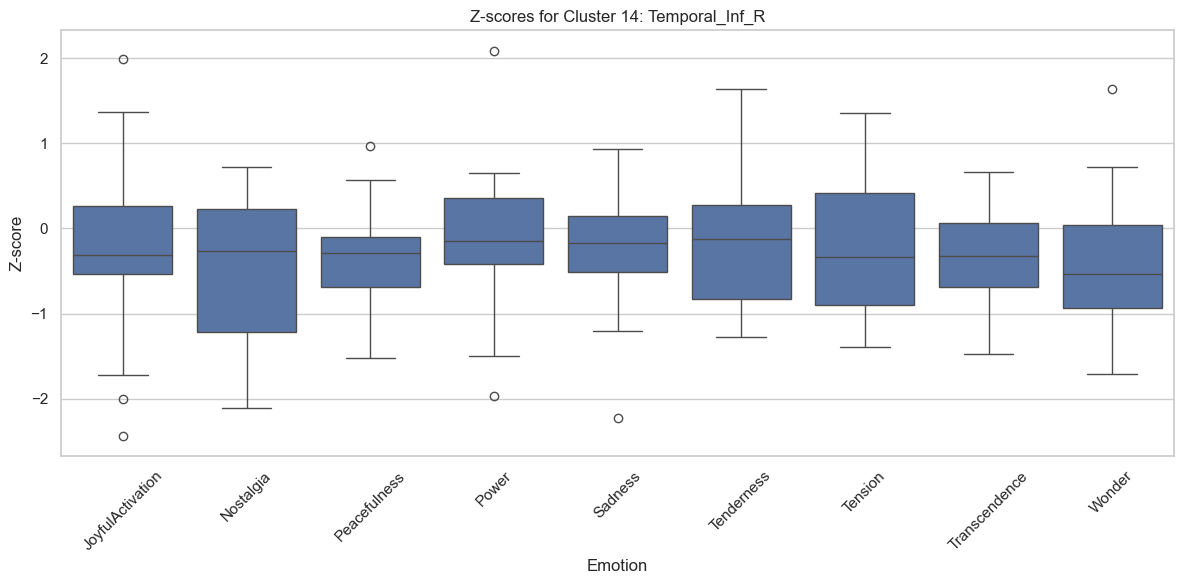

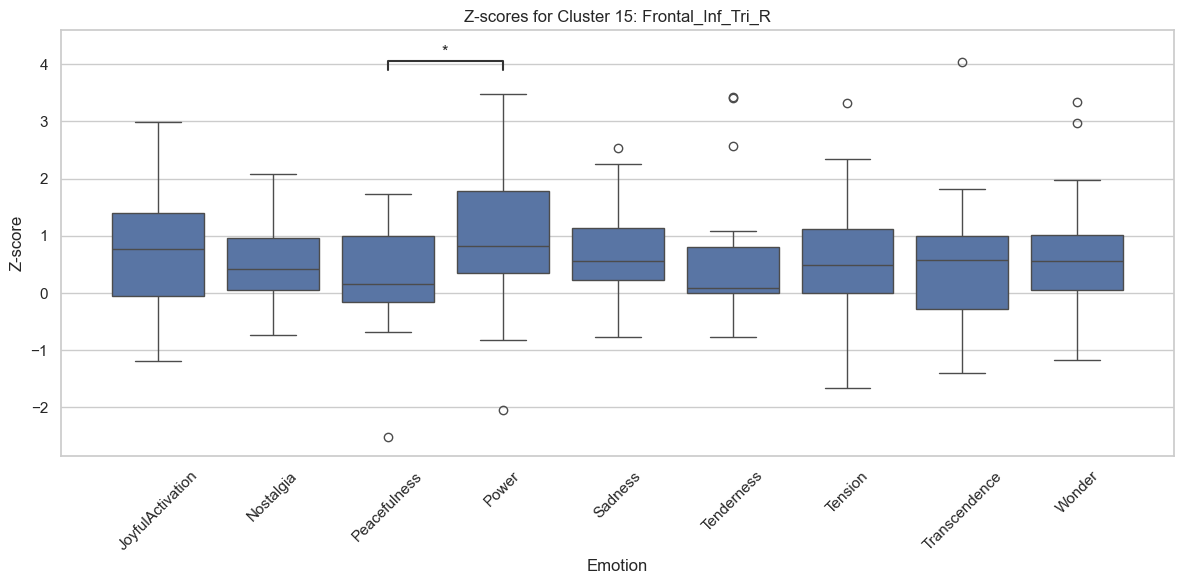

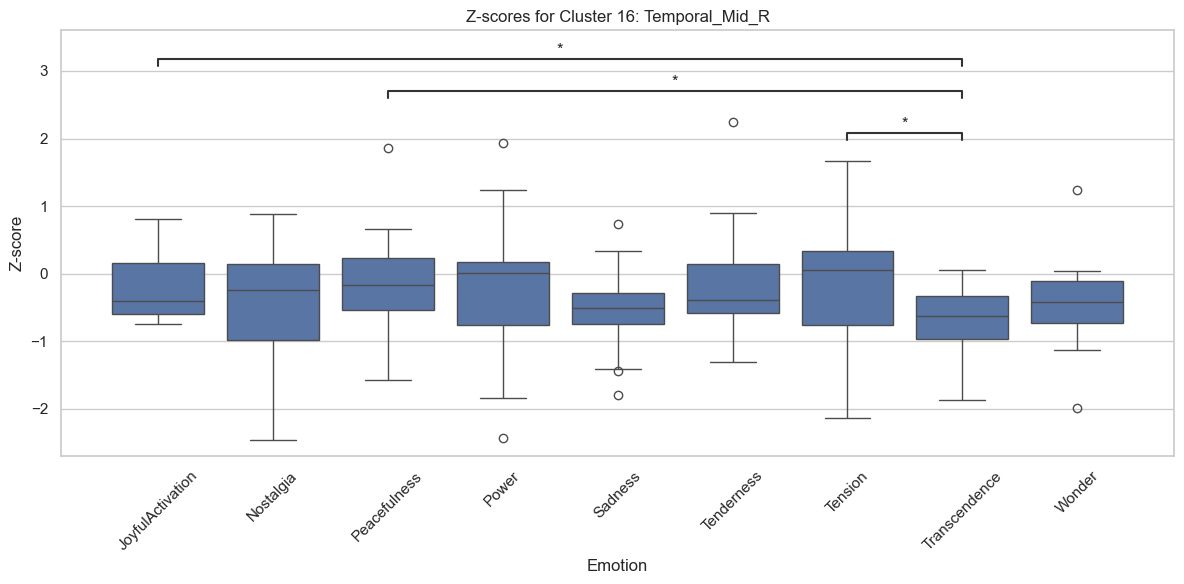

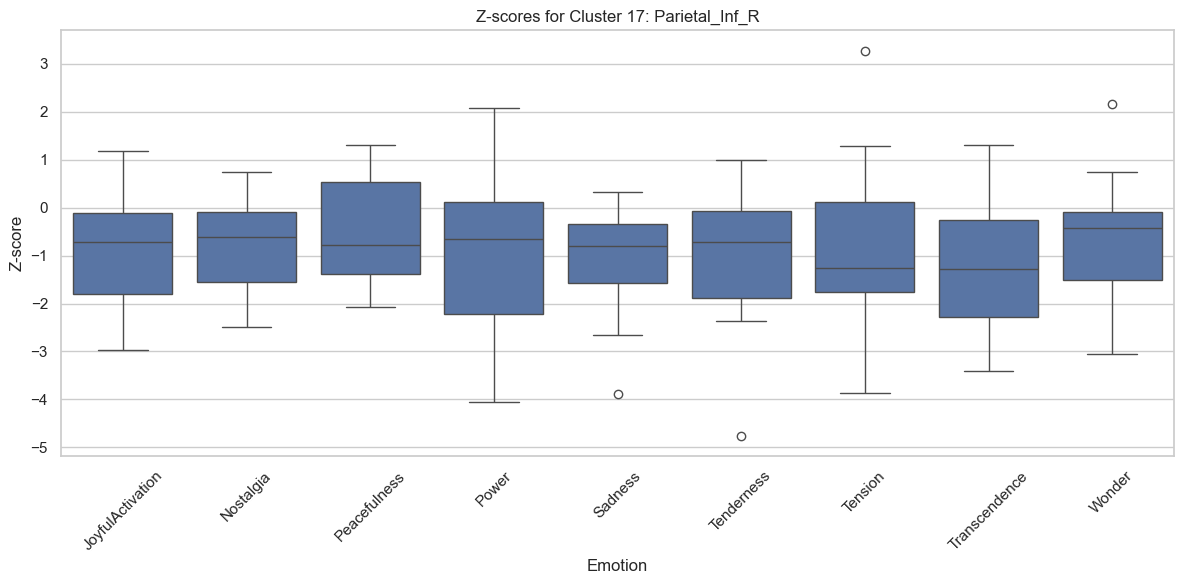

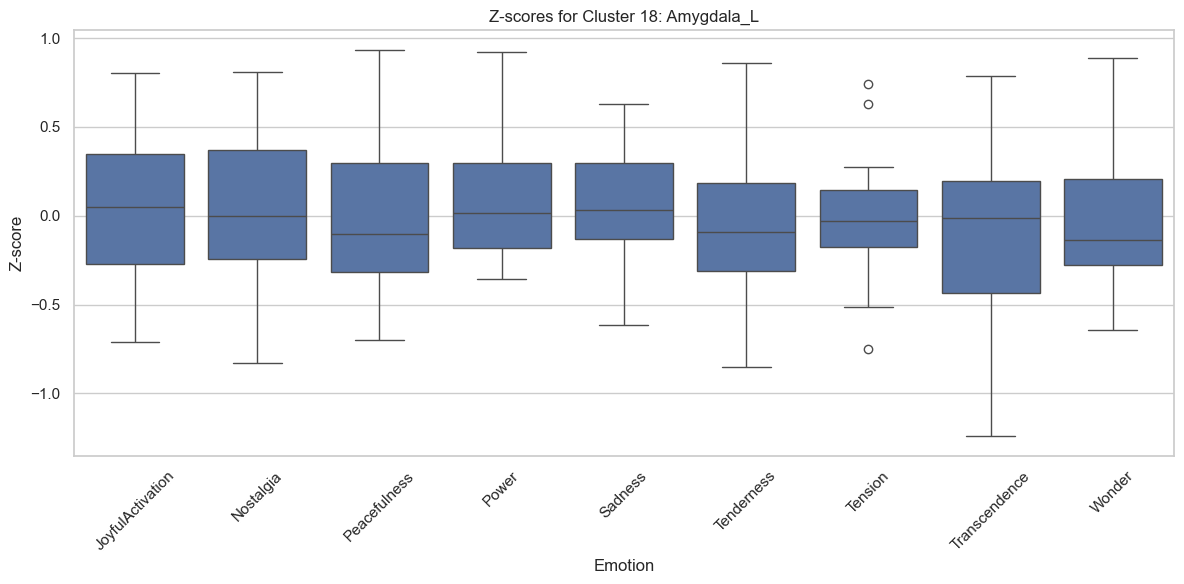

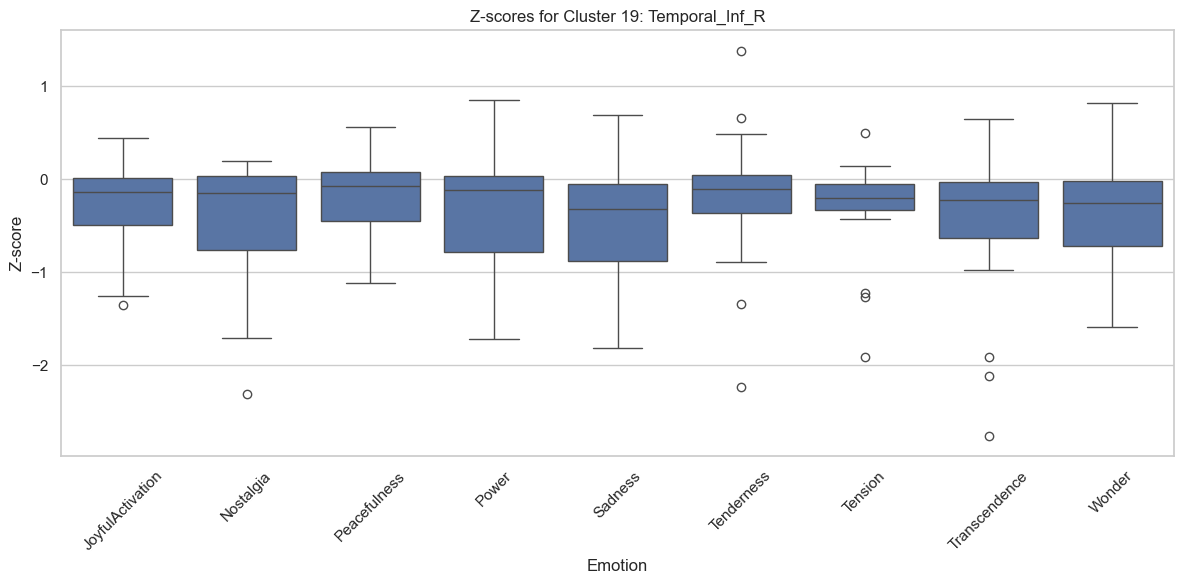

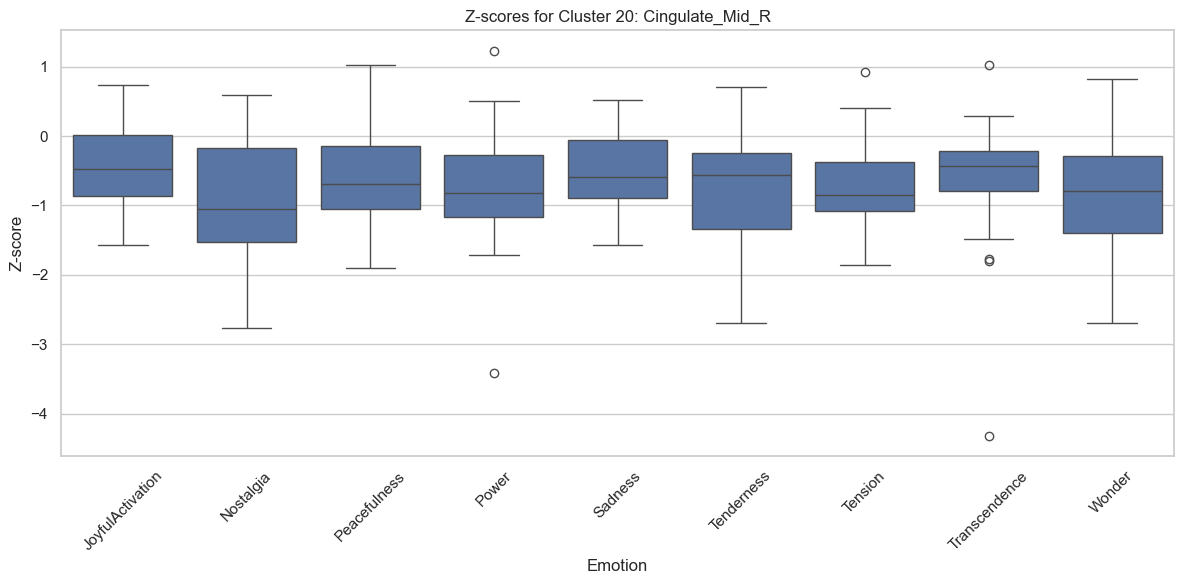

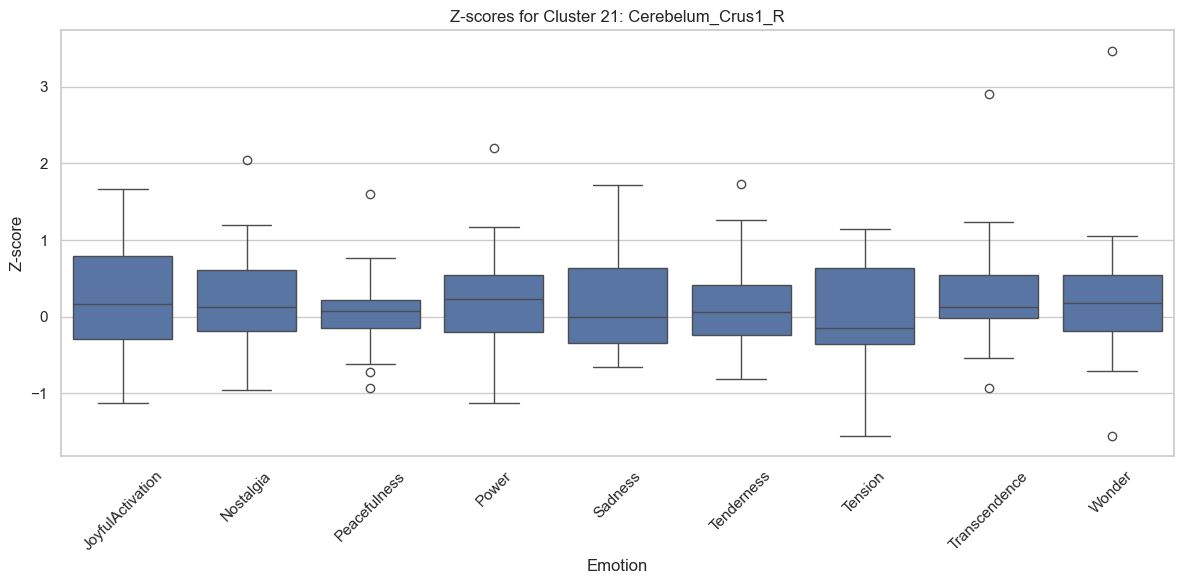

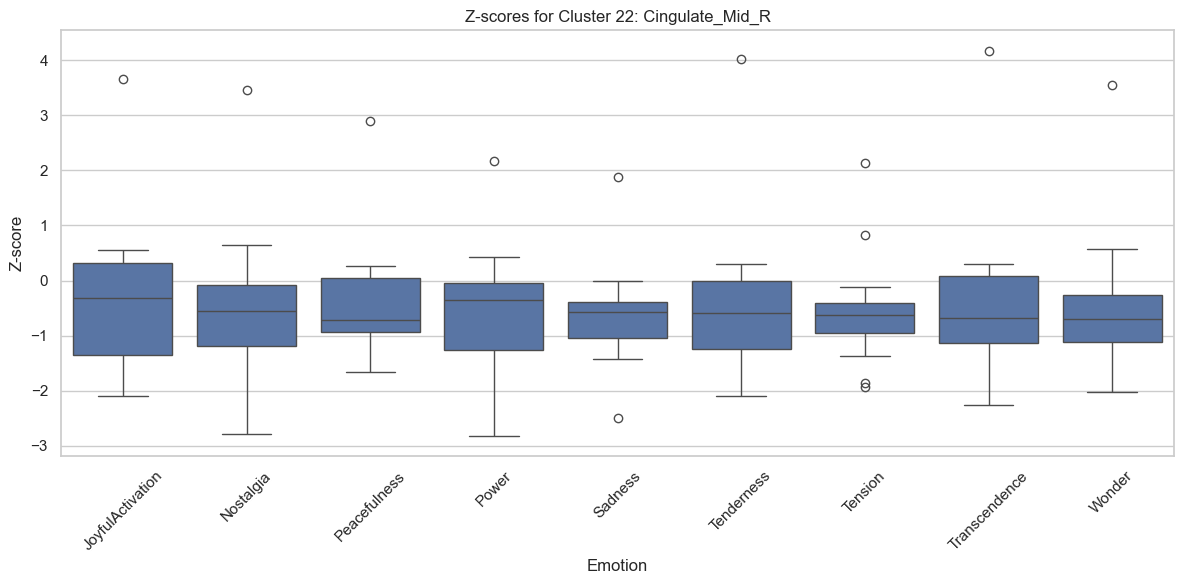

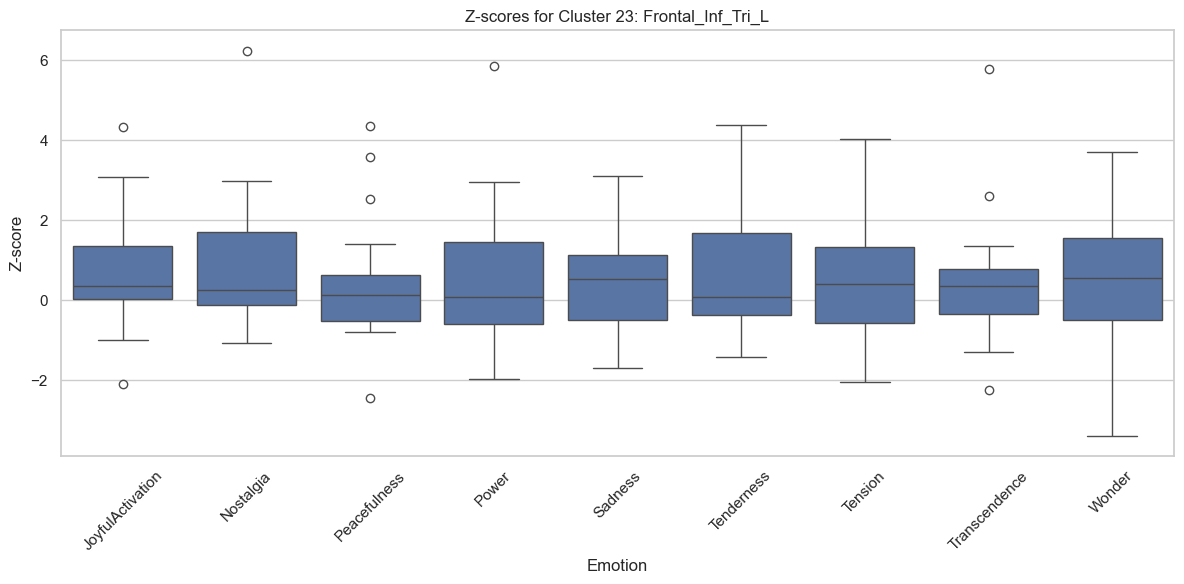

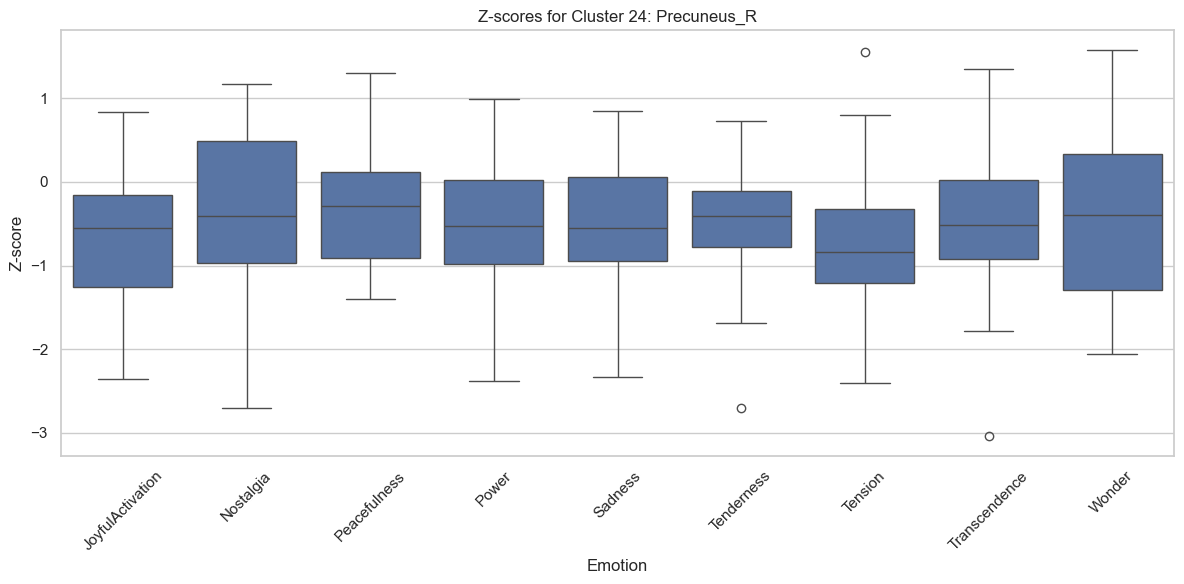

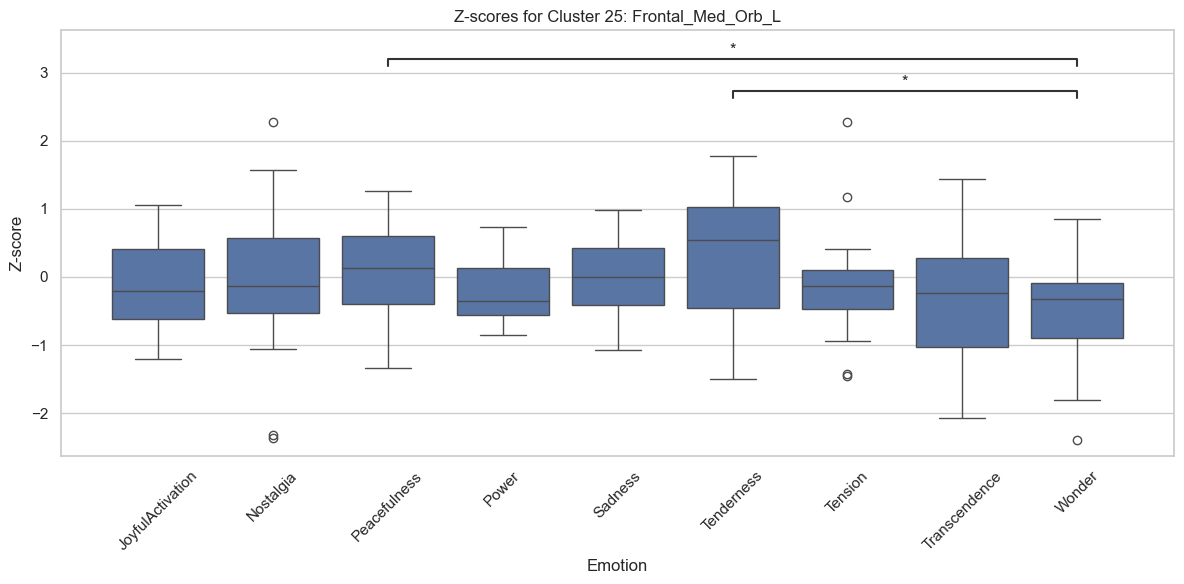

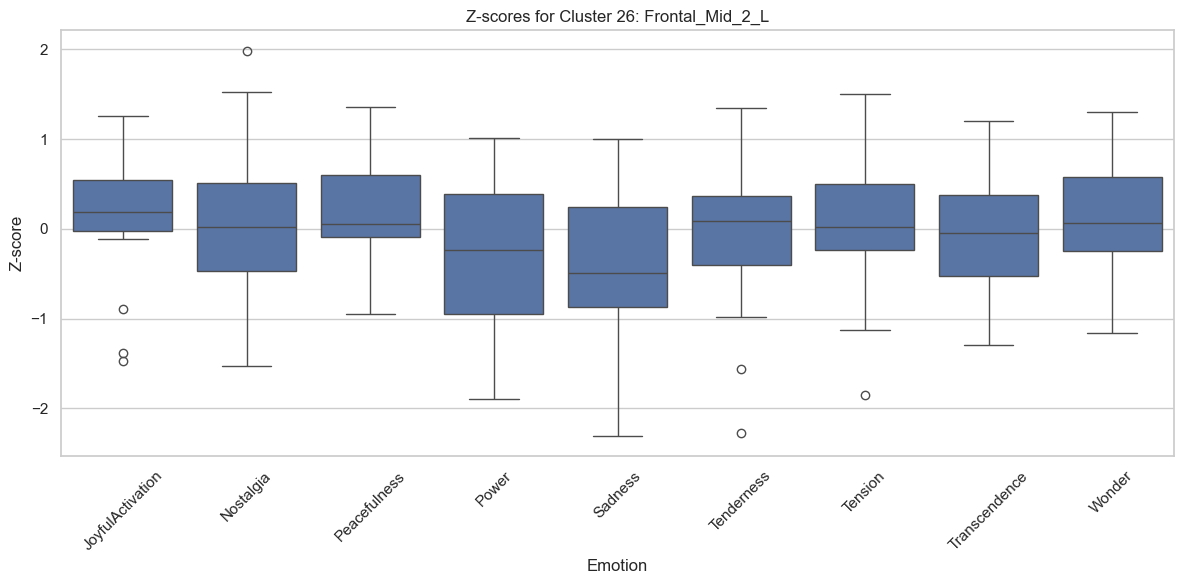

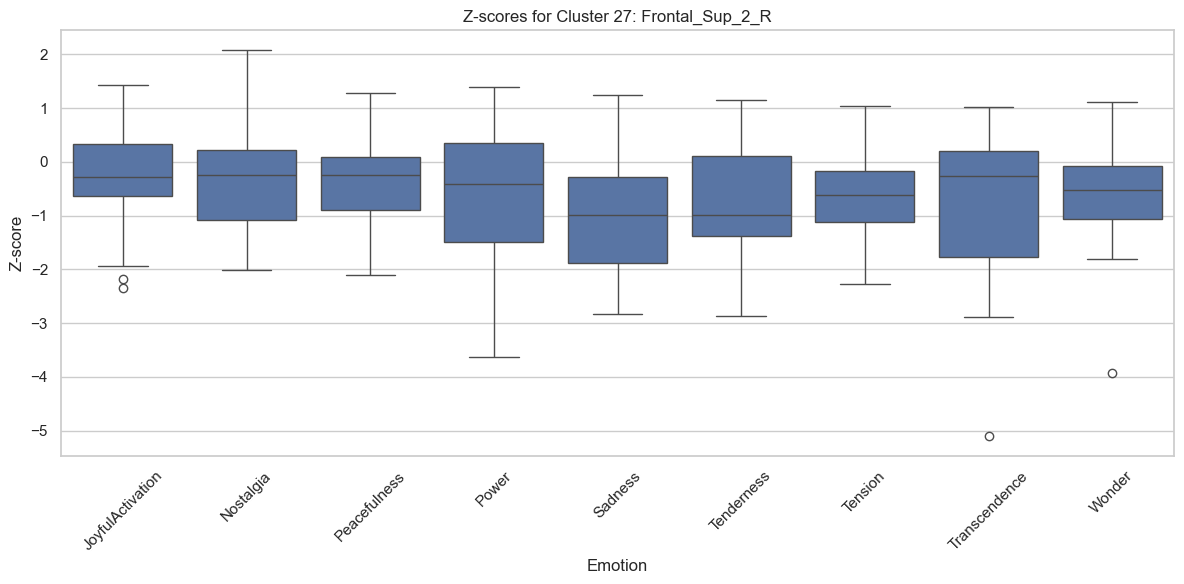

In [6]:
# Boxplot z-scores for all clusters, all emotions, ignoring NaNs
# Perform statistical tests to determine if the z-scores are significantly different between the emotions - use non parametric tests
import seaborn as sns
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt

# Create a DataFrame
z_scores_df = pd.DataFrame(
    z_scores_clean.reshape(-1, z_scores_clean.shape[-1]), columns=[f"Cluster {i + 1}" for i in range(z_scores_clean.shape[-1])]
)
z_scores_df["Emotion"] = np.tile(emotion_names, len(subject_list))
z_scores_df["Subject"] = np.repeat(subject_list, len(emotion_names))

# Define pairs of emotions for comparison
pairs = [(emotion1, emotion2) for i, emotion1 in enumerate(emotion_names) for emotion2 in emotion_names[i + 1 :]]

# Plot
sns.set_theme(style="whitegrid")

# Iterate over all clusters
for cluster_idx, cluster in enumerate(z_scores_df.columns[:-2]):  # Exclude "Emotion" and "Subject" columns
    plt.figure(figsize=(12, 6))
    ax = sns.boxplot(x="Emotion", y=cluster, data=z_scores_df)
    ax.set_title(f"Z-scores for {cluster}: {df.iloc[cluster_idx]['aal']}")
    ax.set_ylabel("Z-score")
    ax.set_xlabel("Emotion")
    plt.xticks(rotation=45)

    # Add statistical annotations
    annotator = Annotator(ax, pairs, data=z_scores_df, x="Emotion", y=cluster)
    annotator.configure(test="Mann-Whitney", text_format="star", loc="inside", verbose=0, hide_non_significant=True, comparisons_correction=None)
    annotator.apply_and_annotate()

    plt.tight_layout()
    plt.show()


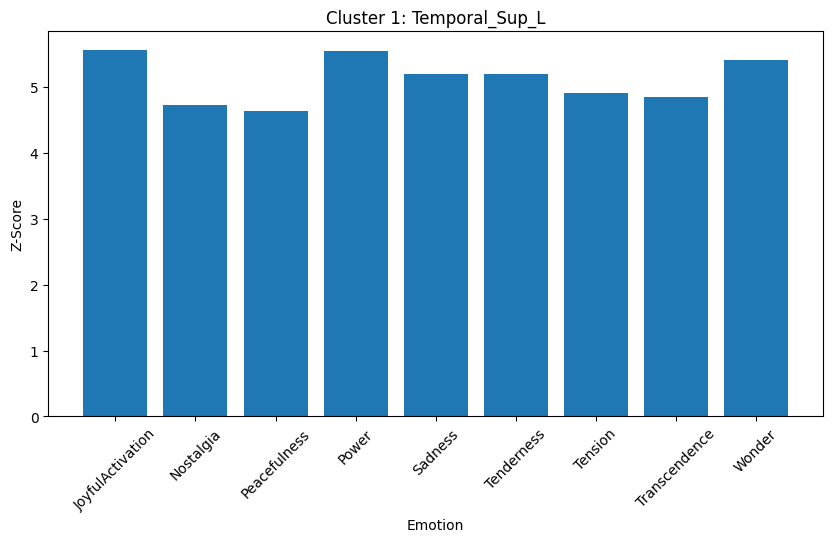

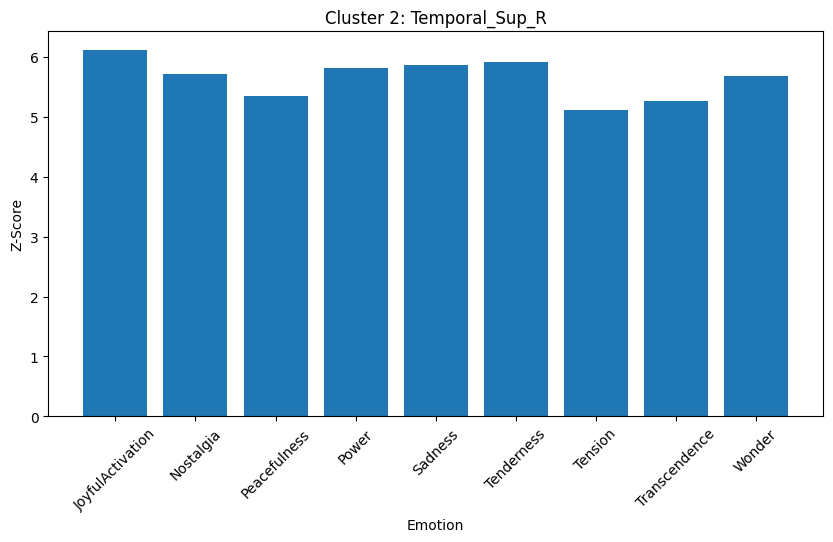

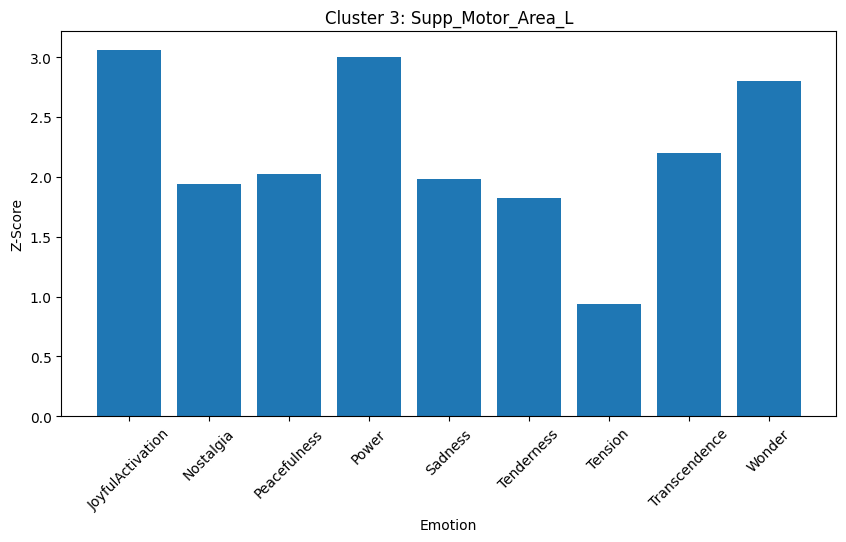

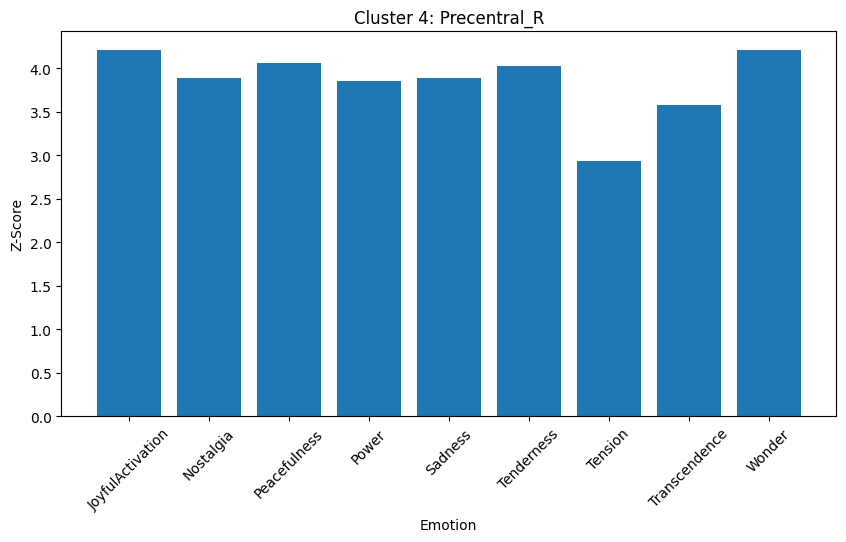

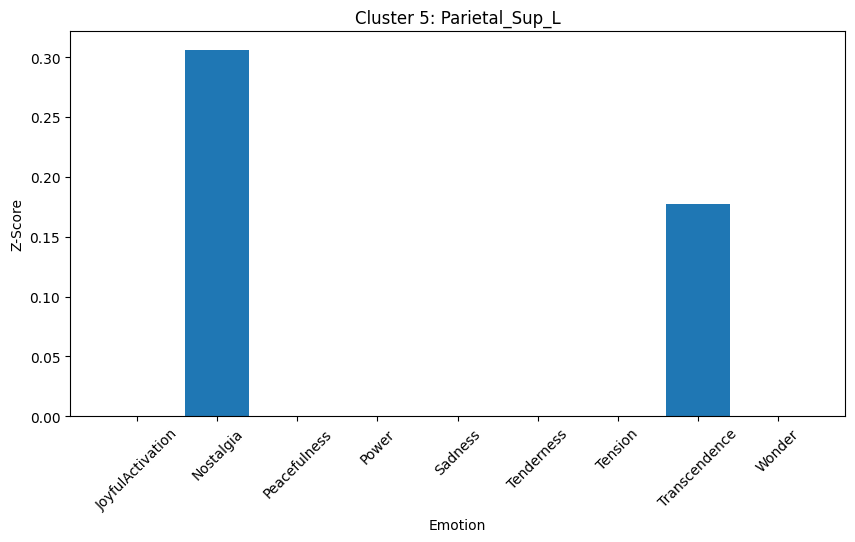

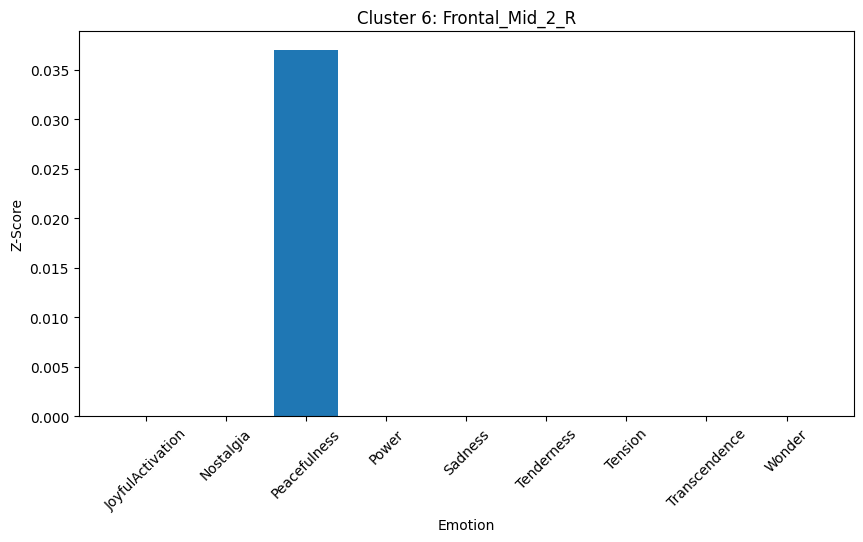

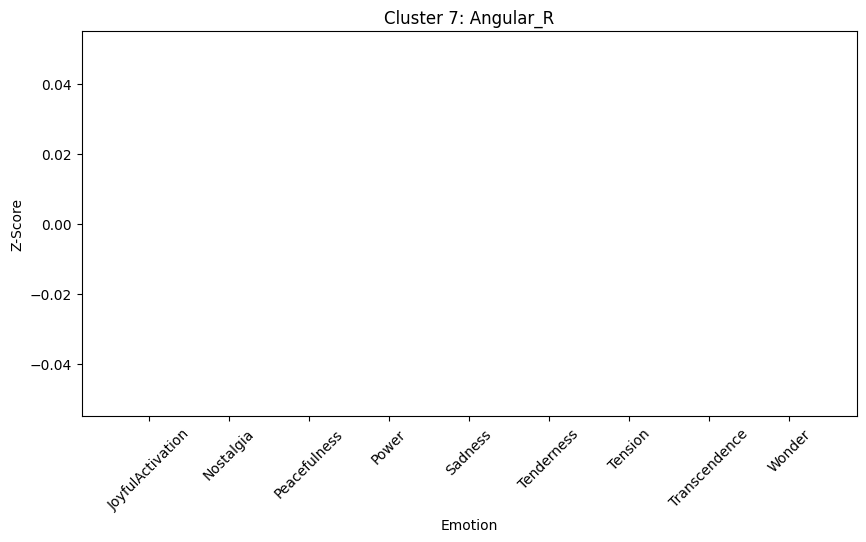

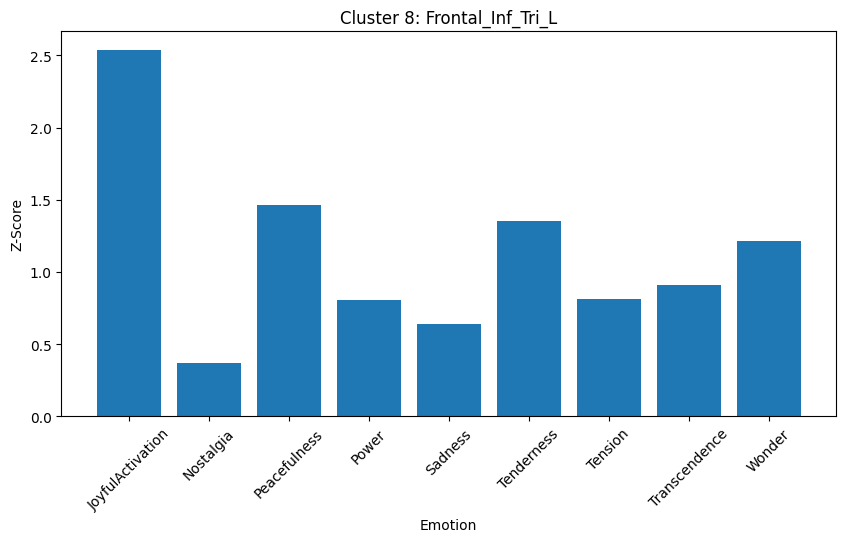

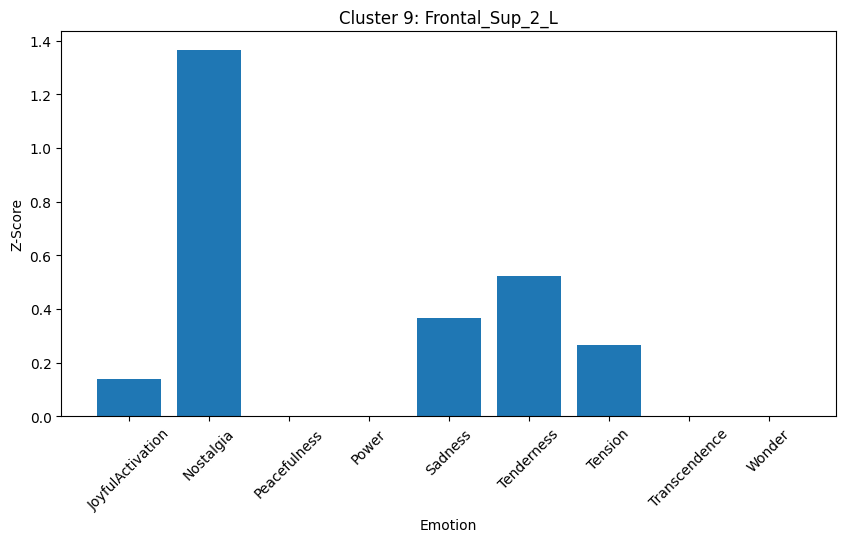

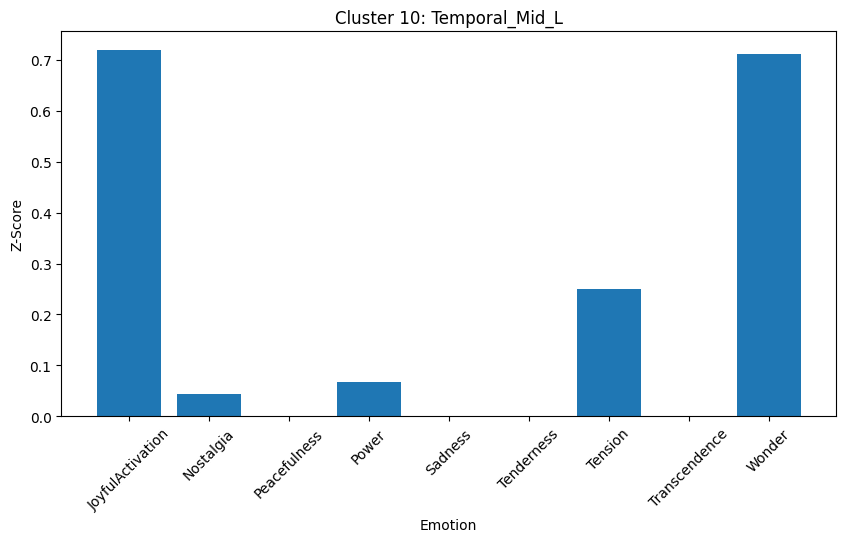

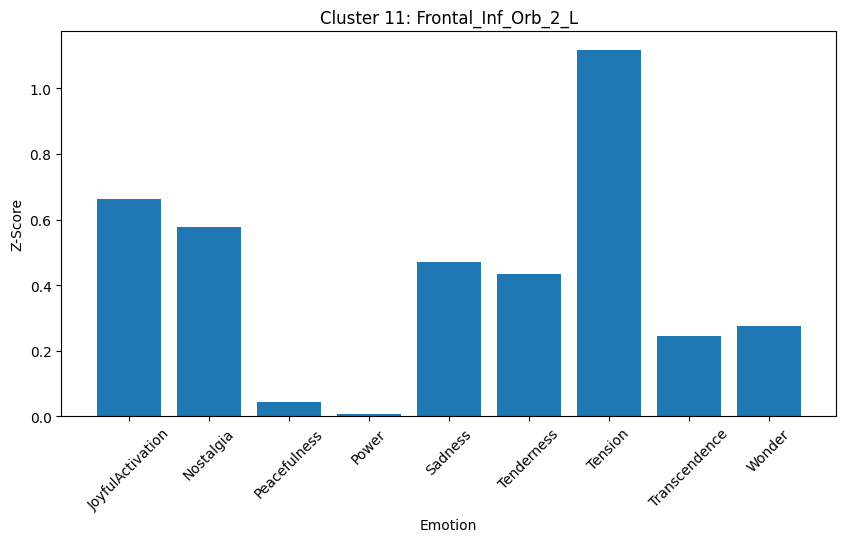

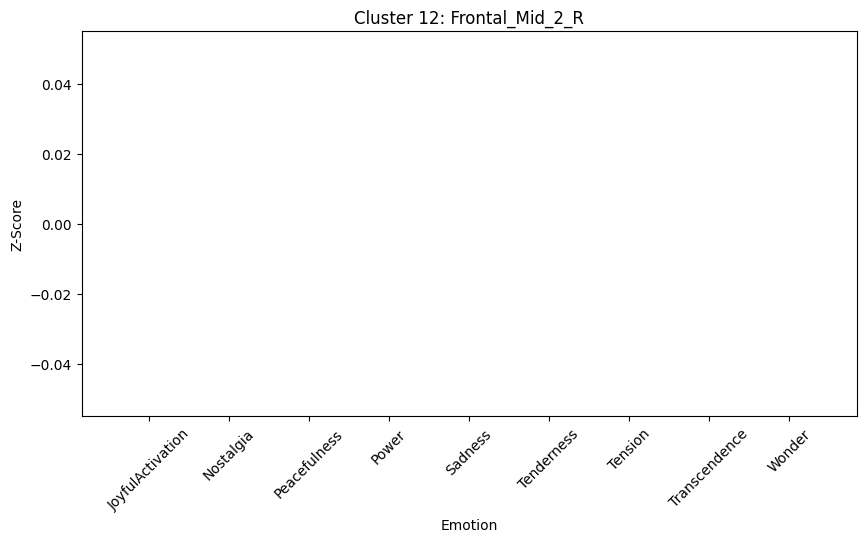

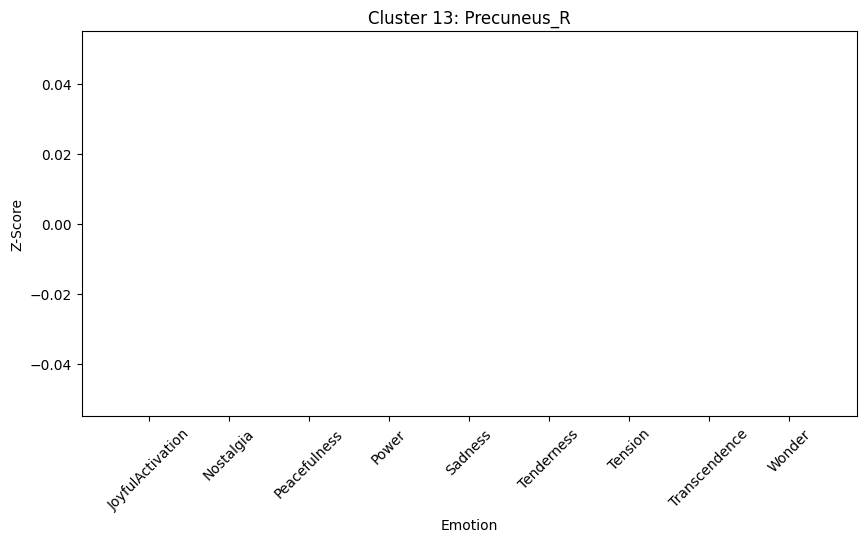

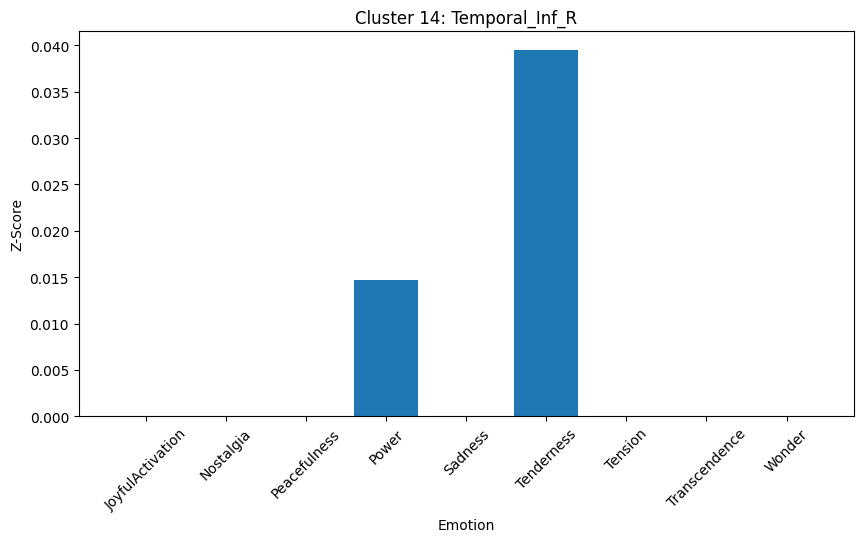

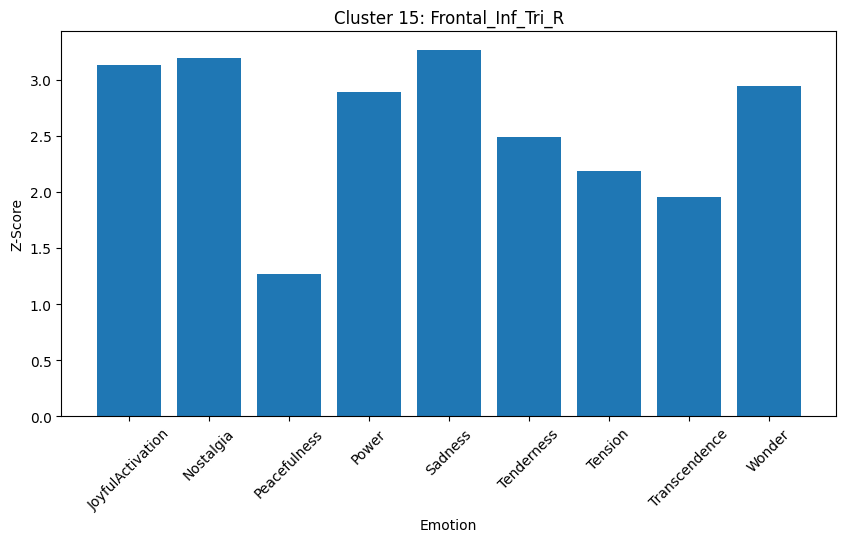

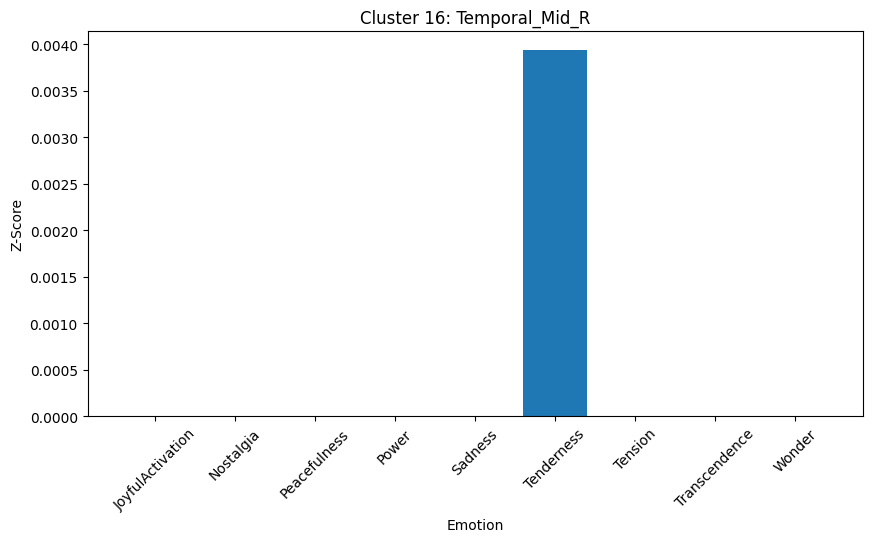

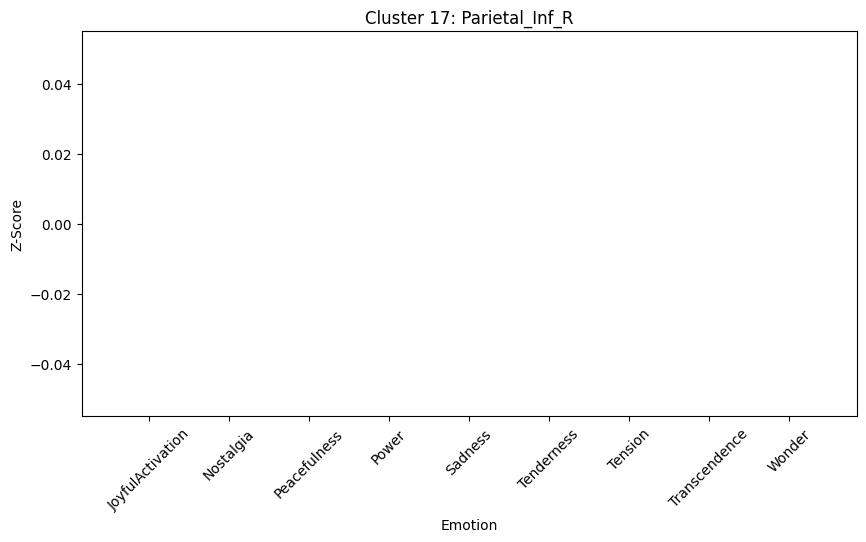

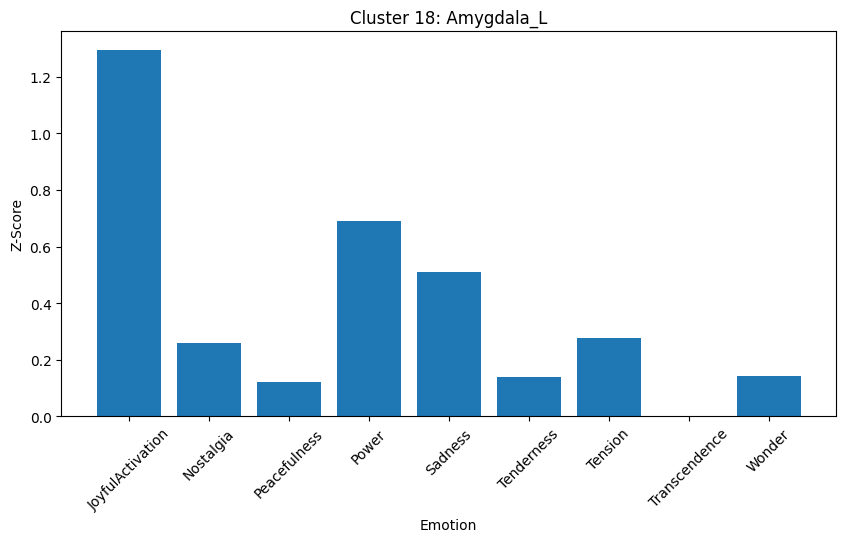

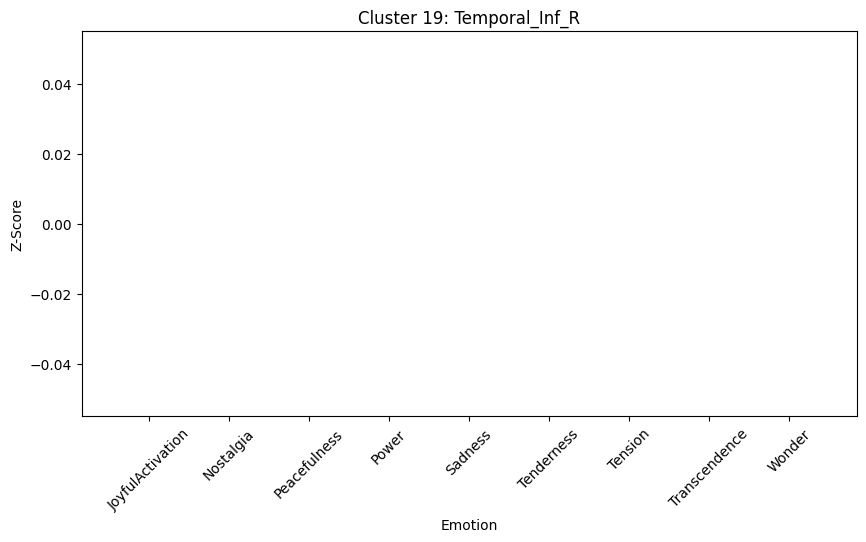

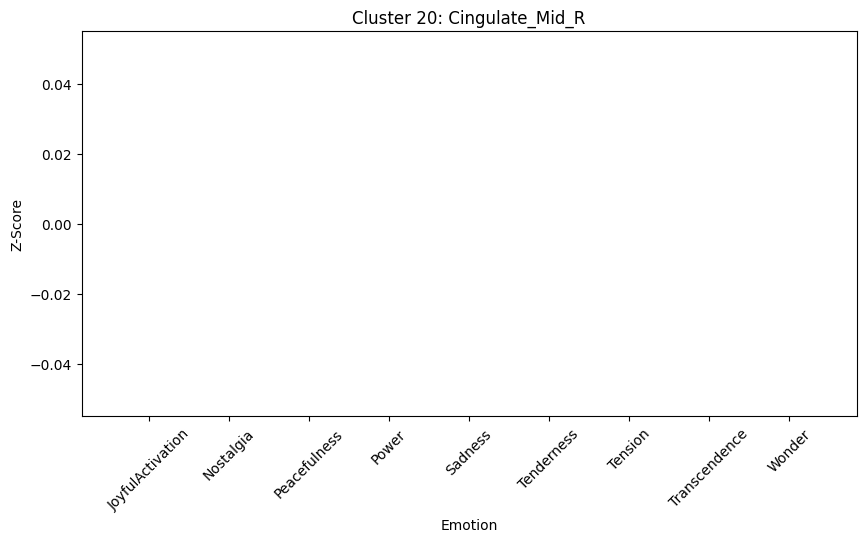

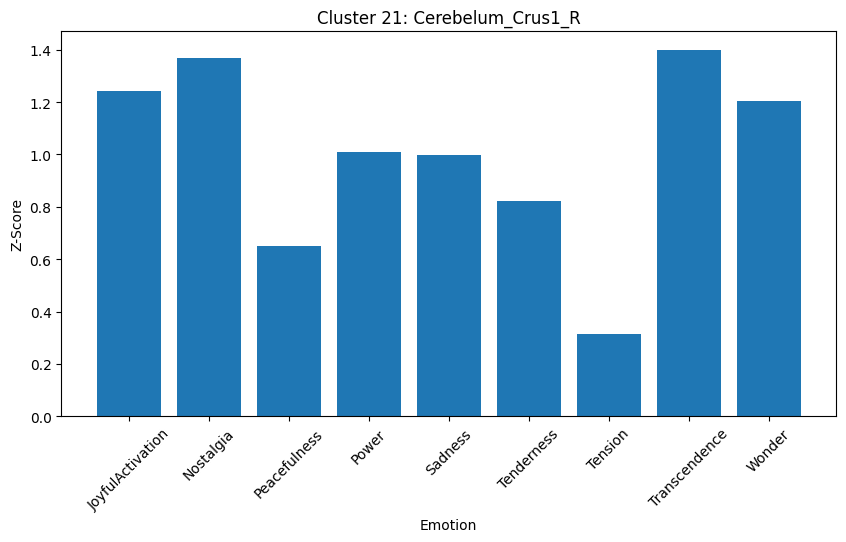

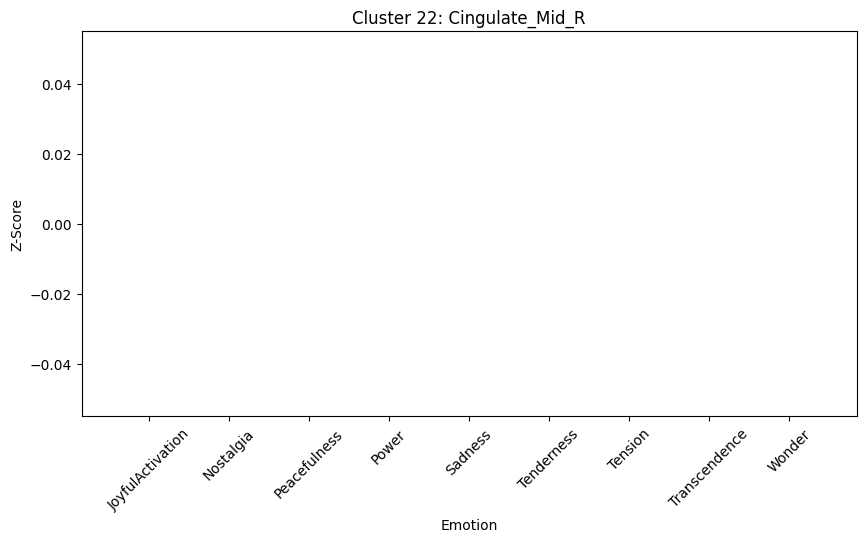

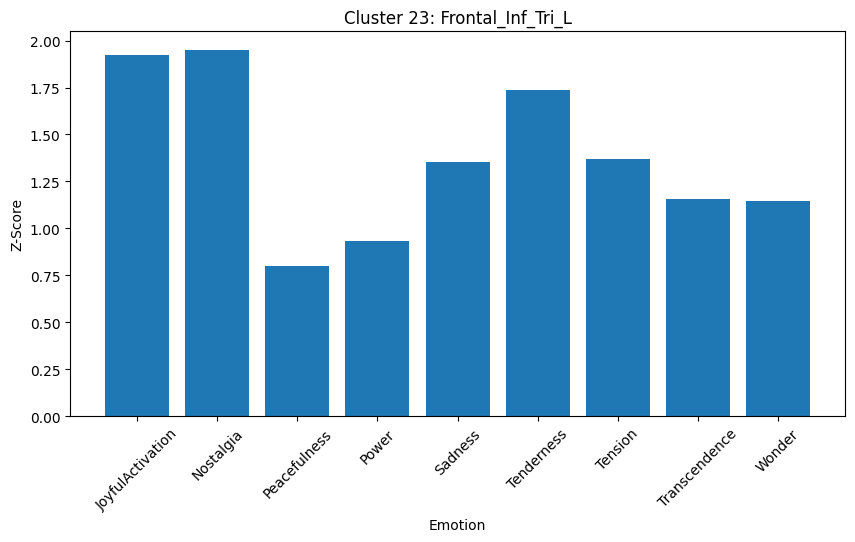

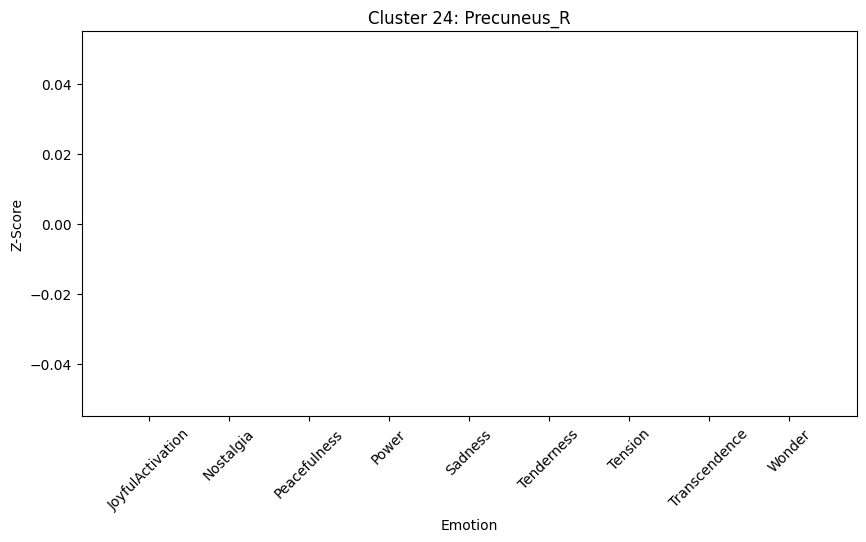

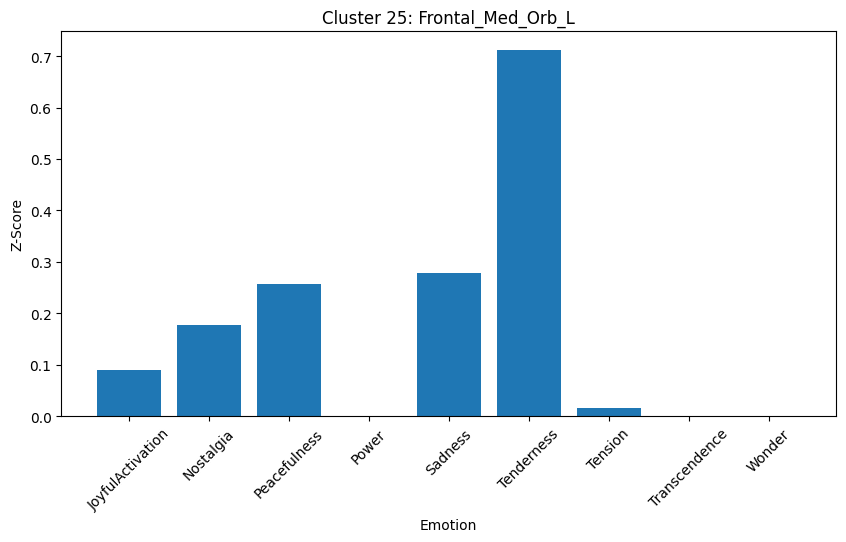

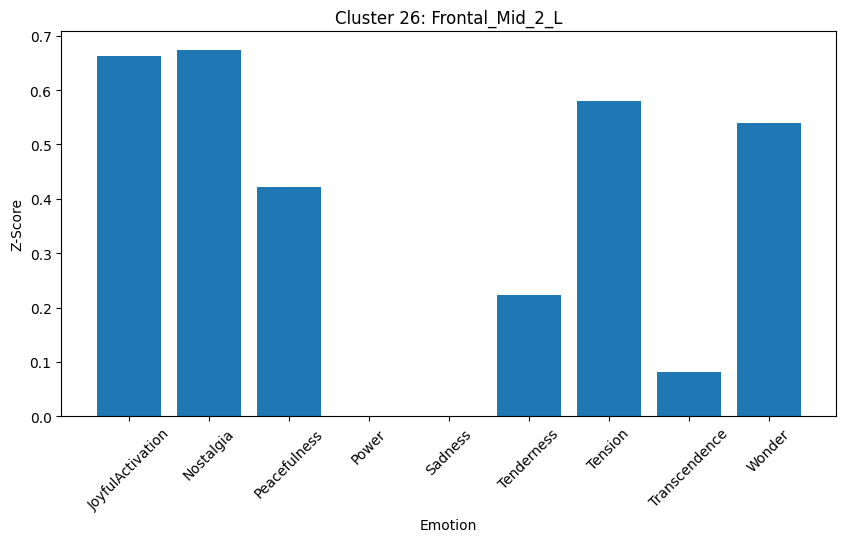

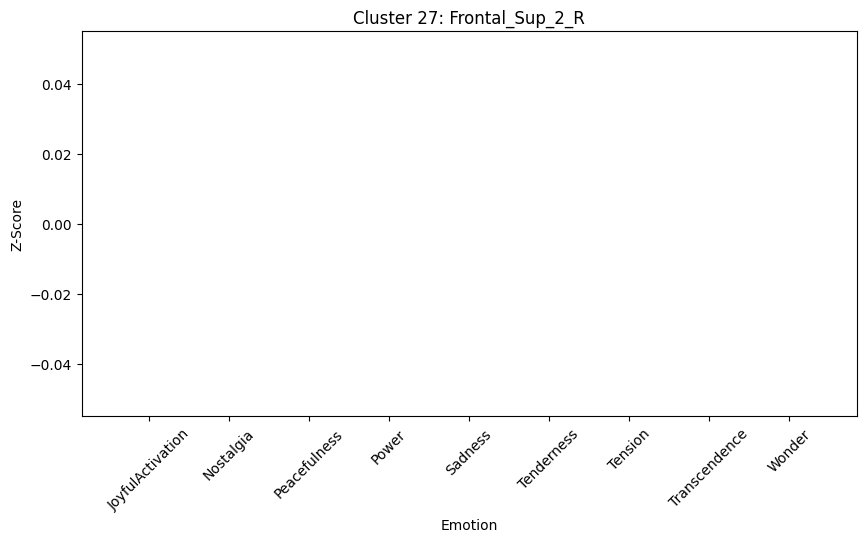

In [7]:
# Plot z-scores for all clusters
import matplotlib.pyplot as plt

for cluster_idx in range(len(coords)):
    plt.figure(figsize=(10, 5))
    plt.bar(emotion_names, z_scores[:, cluster_idx])
    plt.title(f"Cluster {cluster_idx + 1}: {df.iloc[cluster_idx]['aal']}")
    plt.ylabel("Z-Score")
    plt.xlabel("Emotion")
    plt.xticks(rotation=45)
    plt.show()

In [8]:
# Get the z-score maps for the nine emotions

c_idx = 0

z_map_g = os.path.join(out_dir_group, f"group_task-02a_stat-z_con-{emotion_names[c_idx]}.nii.gz")

# clean_map_g, threshold_g = threshold_stats_img(z_map_g, alpha=alpha, height_control=hc, cluster_threshold=ct)

# print(f"Threshold: {threshold_g}")

# threshold clean_map_g to only show positive values
clean_map_g = math_img("np.maximum(img, 0)", img=z_map_g)

# get a binary mask based on clean_map_g
mask_g = math_img("img > 0", img=clean_map_g)

In [9]:
# apply masker to clean_map_g
z_scores = masker.fit_transform(clean_map_g)

<BarContainer object of 27 artists>

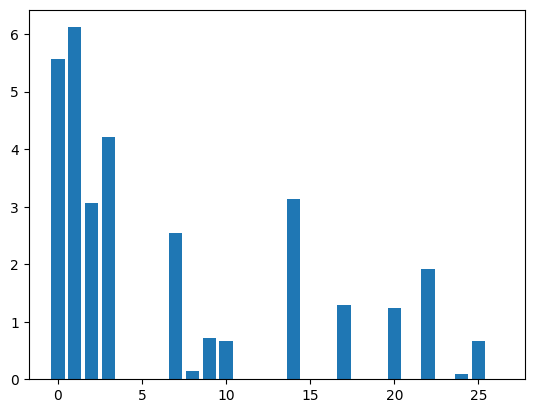

In [10]:
# plot the z-scores in bar plot
import matplotlib.pyplot as plt

plt.bar(range(len(z_scores[0])), z_scores[0])